# 42578 Project: Advanced Business Analytics
## Title: Bias-detection systems in job descriptions and exploratory analysis of underrepresented groups in the workforce
### Theme: AI for the betterment of society
#### Group members:

- Anna Matzen - s214978 
- Anne Moll-Elsborg - s214986
- Kalle Leander Johansen - s204099
- Paula Granlund - s215001

#### Date: May 2025

## Introduction
Extensive research demonstrates that organizations with diverse workforces consistently outperform their peers across virtually every metric. Diversity enriches all aspects of business, from front-line employees to executive leadership.

By welcoming a wide range of perspectives, working styles, and experiences, companies foster innovation, integration, and sustainable growth. Organizations that proactively cultivate and attract diverse talent position themselves for greater long-term success.

A balanced workforce begins with job advertisements that are free from unconscious bias. Employers who prioritize inclusive language demonstrate forward-thinking values and attract a broader, more diverse pool of qualified candidates.

Unconscious biases within job descriptions can inadvertently keep highly qualified candidates from applying. These biases commonly appear in both the language and format of job postings. By carefully reviewing and revising job advertisements, organizations can eliminate these barriers and ensure they appeal to all suitable applicants.

**Note:** *Unconscious bias* refers to implicit attitudes, stereotypes, or assumptions about certain groups of people that individuals hold without conscious awareness. These biases are shaped by personal experiences, cultural influences, and societal norms, and they can unintentionally influence decisions, behaviors, and interactions, often leading to unfair outcomes or discrimination even when people consciously believe in equality and fairness.

In this assignment, we analyze the presence of gender bias in Danish job advertisements. Using a combination of semantic similarity analysis, weak labeling, and machine learning classification, we investigate how biased language manifests in job descriptions and how it can be detected. Our goal is to uncover actionable insights that support fairer recruitment practices and contribute to more inclusive hiring pipelines.

## Motivation and related studies
The study "Evidence That Gendered Wording in Job Advertisements Exists and Sustains Gender Inequality" by Danielle Gaucher and Justin Friesen (University of Waterloo) demonstrated how gender-coded language in job advertisements affects applicants’ perceptions. Participants were shown ads containing different kinds of gendered wording, and the researchers recorded how appealing the jobs seemed and how strongly participants felt they "belonged" in the described occupations.

Despite widespread egalitarian ideals, the research highlights that women remain underrepresented in many gender-skewed fields, including engineering, business leadership, and the natural sciences. Job advertisements are identified as an institutional-level factor that perpetuates gender inequality by reinforcing stereotypes through subtle wording, which can discourage women from applying.

Two findings from the study are particularly relevant:

- Job ads for male-dominated occupations systematically contain more masculine-coded language (e.g., “leader,” “competitive,” “dominant”) than those in female-dominated fields.
- No equivalent increase in feminine-coded terms (e.g., “support,” “understand,” “interpersonal”) is found in ads for female-dominated roles. This asymmetry aligns more with social dominance theory than social role theory.

From a practical perspective, the results suggest the importance of consciously revising job advertisements to remove unintended gender bias, thus promoting gender diversity and inclusion in workplaces.

**By now, it should be clear why recognizing and addressing bias in hiring practices is essential - and why eliminating unconscious bias must begin from the earliest stage: the job description itself.**

## Exploratory analysis

In the previous section, we referenced that “women remain underrepresented in male-dominated fields.” While this finding originates from a 2011 U.S. study, more recent research continues to support similar patterns. To validate this assumption in a Danish context, and to ground our bias detection work in empirical reality, we analyze gender distributions across both education and employment sectors in Denmark, using data from 2020.

This analysis compares:
- The percentage of women **graduating** from different educational fields
- The percentage of women **employed** in corresponding sectors

The goal is to identify structural gaps between education and labor market participation by gender, and to observe how gender dominance persists or shifts between these two stages.

The data used to assess the proportion of women across various educational fields in Denmark was sourced from the Danish Ministry of Higher Education and Science. It provides an aggregated overview of female student enrollment in each university program, alongside the total number of enrolled students. However, the dataset is limited to Danish universities and covers only the years 2019 and 2020. As a result, it does not include information on short-cycle or medium-cycle higher education programs, which are therefore excluded from the subsequent analysis.

The data used to evaluate the proportion of women employed across corresponding sectors in Denmark was obtained from Statistics Denmark via their official online database, StatBank. This dataset provides an aggregated breakdown of male and female employment figures across a wide range of detailed industrial sectors.


In [62]:
# Load Packages
import os # Core libraries
import numpy as np
import time
import re
from collections import Counter
import pandas as pd # Data handling
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
import nltk # Text processing
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer # Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
import torch # Deep learning and embeddings
from sentence_transformers import SentenceTransformer, util
import shap # Model interpretation
import requests # HTTP requests

In [63]:
## Gender distribution in work
path = "CSVfiles/2025411141143535010615LIGEAI3.xlsx" 
df = pd.read_excel(path) 

# Mapping categories
target_groups = {   
    "Landbrug, skovbrug og fisker": [
        "Growing", "Raising", "Plant propagation", "Hunting", "Silviculture", "Logging",
        "Gathering", "Support services to forestry", "Marine fishing", "Freshwater fishing",
        "Marine aquaculture", "Freshwater aquaculture", "farming", "textile", "Fish"
    ],
    "Industri, råstofindvinding og forsyningsvirksomhed": [
        "Mining", "Extraction", "Quarrying", "Manufacture", "Processing", "Production",
        "Refining", "Casting", "Forging", "Repair of fabricated metal products",
        "Electricity", "Gas", "Water", "Sewerage", "Waste", "Remediation", "textile", "textiles", "leather", "wood", "Printing", "stone", "cold",
        "metals", "Machining", "Building", "manufacturing", "Repair", "drilling", "wall", "Bricklayers", "Tyre",  
    ],
    "Bygge og anlæg": [
        "Construction", "Demolition", "Site preparation", "Electrical installation",
        "Plumbing", "Joinery", "Roofing", "Painting", "Glazing", "Building completion"
    ],
    "Handel og transport mv": [
        "Wholesale", "Retail", "Sale", "Trade", "Repair of motor vehicles", "Transport", 
        "Storage", "Warehousing", "Cargo handling", "Postal activities", "Courier", "Supermarkets", "stores", "Taxi", "taxi", 
        "car", "roads", "harbours", "affairs"
    ],
    "Information og kommunikation": [
        "Publishing", "Motion picture", "Broadcasting", "Telecommunications",
        "Computer programming", "IT", "Web portals", "Information service", "media", "Media", "public"
    ],
    "Finansiering og forsikring": [
        "Banking", "Monetary", "Financial", "Insurance", "Pension", "Fund management",
        "Credit", "Securities", "Investment", "Trusts", "Money", "Risk", "analysis"
    ],
    "Ejendomshandel og udlejning": [
        "Real estate", "Housing", "Renting", "Leasing", "Accommodation"
    ],
    "Erhvervsservice": [
        "Legal", "Accounting", "Consultancy", "Engineering", "Scientific", "Advertising",
        "Design", "Translation", "Veterinary", "Employment", "Security", "Cleaning", 
        "Landscape", "Office administrative", "Call centres", "Business support"
    ],
    "Offentlig administration, undervisning og sundhed": [
        "Public administration", "Education", "Hospitals", "Medical", "Dental",
        "Health care", "Nursing", "Residential", "Social work", "school", "schools", "care", "Day-care", "day-care",
        "Kindergartens", 
    ],
    "Kultur, fritid og anden service": [
        "Theatres", "Artists", "Museums", "Libraries", "Sports", "Recreation",
        "Amusement", "Membership organizations", "Hairdresssing", "Beauty treatment",
        "Funeral", "Laundries", "Repair of personal", "Well-being", "Dismantling", "Hotels", "Holiday", "Restaurants", 
        "takeaways", "food", "bars"
    ],
    "Andet": [
        "Activity not stated"
    ]
}

# Classify each industry into a group
def classify_industry(industry): 
    for group, keywords in target_groups.items():
        for keyword in keywords:
            if keyword.lower() in str(industry).lower():
                return group
    return "Andet"

# Apply classification
df["Sector"] = df["Industry"].apply(classify_industry) 

order = [
    "Andet", "Bygge og anlæg", "Erhvervsservice", "Finansiering og forsikring",
    "Handel og transport mv", "Industri, råstofindvinding og forsyningsvirksomhed", 
    "Information og kommunikation", "Kultur, fritid og anden service", 
    "Landbrug, skovbrug og fisker", "Offentlig administration, undervisning og sundhed"
]

# Group by 'Sector' and compute the mean of 'Women (per cent)'
mean_women = df.groupby("Sector")["Women (per cent)"].mean().reset_index() 
mean_women = mean_women.set_index("Sector").loc[order].reset_index()


In [64]:
## Gender distribution in education
education_DK = pd.read_csv("CSVfiles/DK_uddannelser_andelkvinder (1).csv", delimiter = ";")

# Define education group categories
edu_groups = { 
    "Sundhedsvidenskab": ["medicin", "odontologi", "veterinær", "folkesundhed", "farmaci", "biomedicin", "psykologi", "sundhed", "tandplejer", "idræt"],
    "Naturvidenskab": ["arkæologi","naturressourcer","matematik","biologi", "husdyrsvidenskab","fysik", "kemi", "biokemi", "nanoscience", "geologi", "geografi", "bioteknologi", "natur", "molekylær"],
    "Teknisk videnskab (ingeniør)": ["civilingeniør", "diplomingeniør", "teknisk videnskab", "engineering", "maskin", "mekanik", "byg", "elektro", "software"],
    "Samfundsvidenskab": ["jura", "økonomi", "samfund", "statskundskab", "sociologi", "politik", "antropologi"],
    "Humaniora": ["teologi","retorik", "religion","pædagogik", "historie", "filosofi", "dansk", "sprog", "engelsk", "litteratur", "kultur", "lingvistik", "græsk", "historie", "latin"],
    "Erhvervsøkonomi": ["erhvervsøkonomi", "business", "marketing", "ha", "forsikringsmatematik"],
    "Information og kommunikationsteknologi": ["datalogi", "it", "data", "informatik", "kommunikation", "software", "machine learning"]
}

# Sectorgroups for educations and related keywords
branche_keywords = { 
    "Bygge og anlæg": ["byg", "arkitekt", "landinspektør"],
    "Landbrug, skovbrug og fisker": ["biologi","landbrug", "skov", "fiskeri", "husdyr", "naturressourcer", "agro", "geografi"],
    "Industri, råstofindvinding og forsyningsvirksomhed": ["ingeniør", "produktion", "mekanik", "maskin", "proces", "råstof", "energiteknik"],
    "Information og kommunikation": ["datalogi","kommunikation","data", "software", "informatik", "it", "computer", "informationsteknologi", "medialogi"],
    "Ejendomshandel og udlejning": ["ejendom"],
    "Handel og transport mv": ["handel", "logistik", "shipping", "trade"],
    "Finansiering og forsikring": ["økonomi", "forsikring", "finans", "forsikringsmatematik"],
    "Erhvervsservice": ["business", "erhvervs", "marketing", "projektledelse", "innovation"],
    "Kultur, fritid og anden service": ["kultur","musik", "crafts", "design", "kunst", "æstetik", "teater", "film", "idræt", "medie", "journalistik"],
    "Offentlig administration, undervisning og sundhed": [
        "sprog","uddannelse", "politik", "medicin", "psykologi", "pædagogik", "undervisning", "tandplejer", "sundhed", "socialrådgiver", "jura", "statskundskab", "farmaci", "odontologi", "antropologi"
    ]
}

# Classification function
def classify_education(name): 
    name_lower = name.lower()
    for group, keywords in branche_keywords.items():
        for keyword in keywords:
            if keyword in name_lower:
                return group
    return "Andet"

edu_df = pd.DataFrame(education_DK, columns=["Studieretning", "Andel kvinder 2020", "Antal studerende i alt"]) 
edu_df["Sector"] = edu_df["Studieretning"].apply(classify_education)

# Calculate the mean of each andel af kvinder by studieretning
group_means = edu_df.groupby("Sector")["Andel kvinder 2020"].mean().reset_index() 


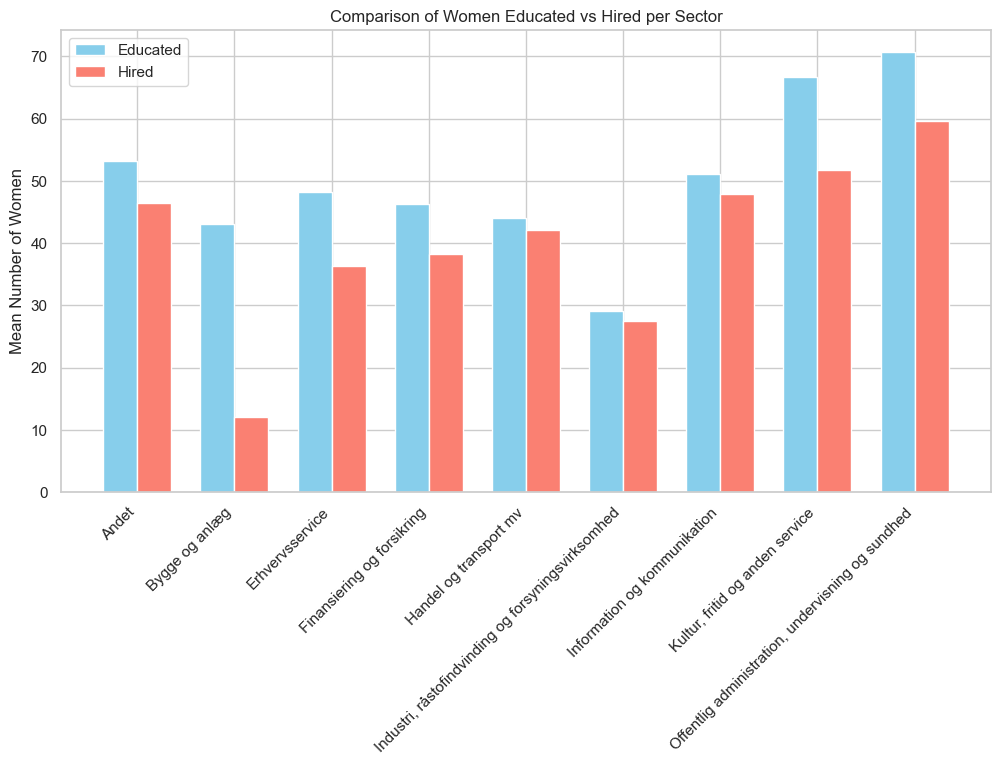

In [65]:
## Plot
group_means = group_means.rename(columns={"Andel kvinder 2020": "Educated"}) 
mean_women = mean_women.rename(columns={"Women (per cent)": "Hired"})

# Merge education and employment data by sector
merged = pd.merge(group_means, mean_women, how="outer", on="Sector") 

# Merge education and employment data by sector
merged = pd.merge(group_means, mean_women, how="outer", on="Sector") 

sector_order = [ 
    "Andet", "Bygge og anlæg", "Erhvervsservice", "Finansiering og forsikring",
    "Handel og transport mv", "Industri, råstofindvinding og forsyningsvirksomhed", 
    "Information og kommunikation", "Kultur, fritid og anden service", 
    "Landbrug, skovbrug og fiskeri", "Offentlig administration, undervisning og sundhed"
]
merged["Sector"] = pd.Categorical(merged["Sector"], categories=sector_order, ordered=True)
merged = merged.sort_values("Sector")
merged = merged.dropna(subset=["Sector"])

sns.set_theme(style="whitegrid") 

fig, ax = plt.subplots(figsize=(12, 6)) 

bar_width = 0.35
x = range(len(merged))

ax.bar([i - bar_width/2 for i in x], merged['Educated'], width=bar_width, label='Educated', color='skyblue') 
ax.bar([i + bar_width/2 for i in x], merged['Hired'], width=bar_width, label='Hired', color='salmon')
ax.set_xticks(x) 
ax.set_xticklabels(merged['Sector'], rotation=45, ha='right')
ax.set_ylabel('Mean Number of Women')
ax.set_title('Comparison of Women Educated vs Hired per Sector')
ax.legend()

The figure above highlights the disparity between the proportion of women educated in various sectors and their actual representation in the corresponding workforce. While women constitute a significant share of graduates in fields such as public administration, healthcare, and education, and even in some technical areas, they remain underrepresented in the labor market, particularly in sectors like industry, construction, and business services.

It is important to note that the classification of educational programs and job sectors is based on a custom mapping developed for this analysis. This mapping was designed to align degrees and occupations into broader industry categories to enable direct comparison. While multiple societal factors may contribute to this gap, such as extended career breaks for maternity leave or higher rates of part-time work due to caregiving responsibilities, these explanations alone may not fully account for the observed underrepresentation.

Research has shown that women tend to outperform men academically. A large-scale meta-analysis by Voyer and Voyer (2014)(\*) found that females have earned higher high school grades than males for nearly a century, particularly in language and social sciences, but also in many STEM subjects. This pattern is also reflected in Danish education statistics.

According to Statistics Denmark (2022)(\*\*), women are significantly more likely than men to complete higher education. Among Danes aged 30–35, over half of women (51.2%) have completed a higher education degree, compared to just 36.4% of men.

Taken together, these findings suggest that academic ability is not the limiting factor. Instead, the gap between education and employment points to structural barriers, including potential bias in hiring processes. One such barrier may be gendered wording in job advertisements, which could discourage qualified women from applying or reduce their likelihood of being selected.

(\*) Voyer, D., & Voyer, S. D. (2014). *Gender differences in scholastic achievement: A meta-analysis*. Psychological Bulletin, 140(4), 1174–1204.  
(\*\*) Statistics Denmark. (2022). *Uddannelsesgabet mellem kvinder og mænd øges*. Retrieved April 13, 2025, from [dst.dk](https://www.dst.dk/da/Statistik/nyheder-analyser-publ/nyt/NytHtml?cid=38257)


## Bias-detection

In job advertisements, unconscious bias often manifests subtly through both language and structure. For example, gendered job titles such as *chairman*, *fireman*, or *councilman* implicitly signal a preference for male applicants, which may discourage otherwise qualified candidates from applying. Similarly, the use of gendered pronouns like *he* or *she*, rather than gender-neutral alternatives like *they* or directly addressing the candidate as *you*, can unintentionally reinforce gender stereotypes.

Bias also appears in the description of the ideal candidate. Words like *assertive* or *competitive* are often associated with traditionally masculine traits, while descriptors such as *bubbly* or *nurturing* tend to be coded as feminine. In addition, research suggests that overly detailed job requirements may disproportionately deter women, who are statistically more likely to apply only if they meet all listed criteria, thereby narrowing the pool of applicants.

**Recognizing these challenges, this study focuses on identifying unconscious bias in hiring by analyzing the use of gendered or exclusionary language in job descriptions.**


### Web Scraping

To collect job descriptions for bias analysis, the initial plan was to use the API provided by the job platform Jooble, which allows keyword- and location-based searches. However, this approach proved insufficient, as the API only returns the first sentence of each job description, far too limited for the purposes of this study. A second attempt was made using the Indeed API, but the platform heavily restricts automated access, blocking most API requests. As a result, job descriptions were ultimately collected manually from Indeed and compiled into a CSV file for analysis. While this method was less time-efficient, it enabled the project to move forward without getting delayed by technical or administrative limitations related to API access and web scraping.

Below is how web scraping on Jooble could have been implemented, if there were less strict restrictions. The output can be seen in jooble_jobs_it.csv. 

In [66]:
# Jooble API key
API_KEY = "54cf1d6e-18eb-4731-9057-b336a85ffddb" 

# API URL
URL = f"https://jooble.org/api/{API_KEY}" 

# Search parameters
keyword = "it" 
location = "Denmark"

payload = { 
    "keywords": keyword,
    "location": location,
    "page": 1,
    "searchMode": 1
}

# Send request
response = requests.post(URL, json=payload) 
data = response.json()

# Save to CSV if jobs are found
if "jobs" in data and data["jobs"]: 
    job_list = [{"Title": job["title"], "Description": job["snippet"]} for job in data["jobs"]]
    df = pd.DataFrame(job_list)
    filename = f"jooble_jobs_{keyword}.csv"
    df.to_csv(filename, index=False)
    print(f"Saved job listings to {filename}")
else:
    print("No job listings found or empty response.")

Saved job listings to jooble_jobs_it.csv


### Preprocessing and extraction of frequent words

While the original plan included the possibility of applying classical topic modeling methods (e.g., Latent Dirichlet Allocation), preliminary exploration revealed that the raw job description data contained substantial administrative phrasing, web scraping artifacts, and repetitive generic language.  
As a result, we decided to forgo topic modeling in favor of a more interpretable and direct approach.

Instead, we adopted structured text preprocessing with the goal of extracting the most **frequent, meaningful words** from job postings within **male-dominated** and **female-dominated industries** separately.  
This enables a focused identification of potential **gendered language patterns** that may reflect underlying biases in how different industries advertise roles.

The following code performs:
- Preprocessing of job descriptions (lowercasing, tokenization, and cleaning),
- Removal of standard Danish stopwords and additional domain-specific neutral terms,
- Filtering of irrelevant, non-content words (e.g., locations, administrative phrases),
- Extraction and counting of the most common content-bearing words for each group.

This approach provides a clear, interpretable alternative to traditional topic modeling, aligning closely with the study’s aim of uncovering unconscious bias in job advertisement language.


In [67]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load Danish word list from .dic file
danish_words_path = 'Danish.dic' 

danish_words = set()

with open(danish_words_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Read dictionary words
for line in lines[1:]: 
    word = line.strip().split('/')[0].lower()
    if word:  
        danish_words.add(word)

print(f"Loaded {len(danish_words)} Danish words.")

df = pd.read_csv('job_descriptions_final_final.csv', encoding="utf-8", sep=';', quoting=1)

user_gender_mapping = {0: 'male-dominated', 1: 'female-dominated'}
df['field_gender_user'] = df['Male or female'].map(user_gender_mapping)

# Danish stopwords
danish_stopwords = set(stopwords.words('danish')) 

# Custom extra stopwords
custom_stopwords = danish_stopwords.union({ 
    'indeed', 'dk', 'https', 'com', 're', 'ans', 'from', 'viewjob', 'in', 'the', 
    'st', 'to', 'jk', 'ger', 'hj', 'tter', 'stillingen', 'arbejde', 'job', 'del',
    'vores', 'kan', 'kommune', 'arbejder', 'gode', 'tv', 'fokus', 'samt',
    'mere', 'ved', 'godt', 'forbindelse', 'side', 'lp', 'opret', 'udvikling',
    'mulighed', 'skabe', 'lande', 'and', 'erfaring', 'dine', 'website',
    'konto', 'god', 'bende', 'danmark', 'team', 'samarbejde', 'fuldtid', 
    'tilbyder', 'arbejdsplads', 'rapportering', 'sammen', 'se', 'kollegaer', 
    'pr', 'velkommen', 'dit', 'inden', 'hverdag', 'via', 'glostrup',
    'maj', 'dansk', 'kontakte', 'derfor', 'gerne', 'hele', 'andre', 'stor', 
    'cv', 'ring', 'as', 'will', 'region', 'via', 'plads', 'timer', 'maj', 
    'albertslund', 'rende', 'are', 'is', 'kommer', 'forst', 'mellem', 'ballerup', 
    'roskilde', 'center', 'tid', 'ser', 'baggrund', 'overenskomst', 'virksomhed', 
    'fordel', 'kolleger', 'kollega', 'hver', 'permanent', 'så'
})

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-ZæøåÆØÅ]+', ' ', text)  # Keep Danish letters
    tokens = text.split()
    tokens = [word for word in tokens if word in danish_words and word not in custom_stopwords and len(word) > 1]
    return tokens

df['tokens'] = df['description'].apply(preprocess_text)

male_tokens = df[df['field_gender_user'] == 'male-dominated']['tokens'].sum()
female_tokens = df[df['field_gender_user'] == 'female-dominated']['tokens'].sum()

# Word frequencies
male_word_counts = Counter(male_tokens) 
female_word_counts = Counter(female_tokens)

# Top 20 words
N = 20 
top_male_words = male_word_counts.most_common(N)
top_female_words = female_word_counts.most_common(N)

# Output
print("\nTop words in male-dominated industries:") 
for word, count in top_male_words:
    print(f"{word}: {count}")

print("\nTop words in female-dominated industries:")
for word, count in top_female_words:
    print(f"{word}: {count}")

Loaded 149756 Danish words.

Top words in male-dominated industries:
både: 103
hjælp: 92
før: 91
fortsætter: 87
københavn: 81
søger: 81
får: 78
løbende: 76
ansøgning: 70
sikre: 68
ansvar: 52
spørgsmål: 52
spændende: 48
it: 48
service: 44
få: 39
tæt: 38
høj: 38
kvalitet: 38
tværs: 37

Top words in female-dominated industries:
københavn: 98
både: 94
søger: 88
før: 68
hjælp: 65
fortsætter: 62
faglig: 61
børn: 57
løbende: 56
ansøgning: 55
sygeplejerske: 51
lyst: 47
løn: 46
får: 43
tæt: 42
ansøgningsfrist: 40
trivsel: 40
ansættelse: 40
ansvar: 39
spændende: 38


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kalleleander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kalleleander/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kalleleander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The extracted top words reveal some thematic differences between male- and female-dominated industries:

- In **male-dominated industries**, common words emphasize skills, responsibility, and standards, including terms like **sikre** (ensure), **ansvar** (responsibility), **kvalitet** (quality), and **udvikle** (develop).

- In **female-dominated industries**, common words more often relate to care professions, education, and wellbeing, featuring terms such as **trivsel** (wellbeing), **lyst** (desire/motivation), and **sparring** (coaching/support).

Both groups also share some neutral professional terms such as **faglig** (professional competence), **uddannelse** (education), and **ansvar** (responsibility), highlighting that leadership and professionalism are emphasized across industries, but with different contextual focuses. 

Notably, however, terms like **ansvar** and **uddannelse** are relatively more frequent in male-oriented postings.  
This suggests a greater emphasis on **performance**, **skills acquisition**, and **professional advancement** in the language used when attracting male applicants.

These findings suggest that job advertisement language may reflect broader gendered expectations and cultural norms about desired applicant traits.

Based on the studies of Gaucher et al. and similar, non gender-neutral words have been collected. Some words have been reduced to a 'stem' to cover a range of noun, verb and adjective variants; for instance "compet" covers "compete", "competetive" and "competition".

**Feminine-coded words**

| agree- | affectionate- | child-       | cheer-      | collab-     | commit-     |
|--------|----------------|--------------|-------------|-------------|-------------|
| communal- | compassion- | connect-     | considerate-| cooperat-   | co-operat-  |
| depend-   | emotiona-   | empath-      | feel-       | flatterable-| gentle-     |
| honest-   | interpersonal- | interdependen- | interpersona- | inter-personal- | inter-dependen- |
| inter-persona- | kind- | kinship-     | loyal-      | modesty-    | nag-        |
| nurtur-   | pleasant-   | polite-      | quiet-      | respon-     | sensitiv-   |
| submissive- | support- | sympath-     | tender-     | together-   | trust-      |
| understand- | warm-     | whin-        | enthusias-  | inclusive-  | yield-      |
| share-     | sharin-    |              |             |             |             |

**Masculine-coded words**

| active- | adventurous- | aggress-     | ambitio-    | analy-      | assert-     |
|---------|---------------|--------------|-------------|-------------|-------------|
| athlet- | autonom-     | battle-      | boast-      | challeng-   | champion-   |
| compet- | confident-   | courag-      | decid-      | decision-   | decisive-   |
| defend- | determin-    | domina-      | dominant-   | driven-     | fearless-   |
| fight-  | force-       | greedy-      | head-strong-| headstrong- | hierarch-   |
| hostil- | impulsive-   | independen-  | individual- | intellect-  | lead-       |
| logic-  | objective-   | opinion-     | outspoken-  | persist-    | principle-  |
| reckless- | self-confiden- | self-relian- | self-sufficien- | selfconfiden- | selfrelian- |
| selfsufficien- | stubborn- | superior- | unreasonab- |             |             |


### Bias detection using contextual embeddings and similarity

The first technique used in this analysis to detect unconscious bias in job descriptions is a semantic model to capture deep language patterns. Specifically, we embed both the bias terms and the job description sentences using a pre-trained sentence transformer model and compute the **cosine similarity** between them.

For each sentence in a job description, the similarity to the bias terms is calculated. If any similarity score exceeds a predefined threshold, the sentence is flagged as **potentially biased**. The threshold can be adjusted to increase or decrease the model's sensitivity.

This approach offers a **more flexible and language-aware detection mechanism**, but it also comes with several limitations:

- **Lack of contextual sensitivity:** The model cannot distinguish between different uses of a word. For example, a sentence mentioning "young people" may be flagged due to the similarity with the term *"youthful"*, even if the context is neutral or factual.

- **Risk of false positives:** The model may flag neutral statements as biased. For instance, a sentence with the word *"leader"* could be flagged due to the term *"natural leader"*, even if no biased intent is present.

- **Need for manual verification:** Due to these limitations, any flagged sentences should be manually reviewed. The model’s role is to highlight **potentially** biased language, not to make final judgments. Human oversight remains essential for ensuring fairness and accuracy.

The contextual embedding model MiniLM is used in the following part, and hence there is no need to apply stemming to the job descriptions. The model already handles morphological variations in the texts by endcoding semantic meaning into the vector space and learns context.


In [68]:
# Bias terms from Gaucher et al. and frequent words counter
bias_terms = [ 
"imødekommende", "kærlig", "barn", "munter", "samarbejdende", "engageret",
"fælles", "medfølende", "forbundet", "betænksom", "samarbejdsvillig",
"pålidelig", "følelsesladet", "empatisk", "smigret", "blid",
"ærlig", "menneskelig", "gensidig", "afhængig", "venlig", "slægtskab", "loyal", "beskedenhed", "nagen",
"omsorgsfuld", "behagelig", "høflig", "stille", "følsom",
"underdanig", "støttende", "sympatisk", "øm", "sammen", "troværdig",
"forstående", "varm", "klynkende", "entusiastisk", "inkluderende", "eftergivende", 
"delende", "aktiv", "eventyrlysten", "aggressiv", "ambitiøs", "analytisk",
"atletisk", "kamp", "krig", "pralende", "udfordrende", "forkæmper",
"konkurrencepræget", "selvtillid", "modig", "besluttende", "beslutningstagning", "beslutsom",
"forsvarende", "målrettet", "dominerende", "drevet", "frygtløs",
"kæmpe", "kraftfuld", "grådig", "egenrådig", "hierarkisk",
"fjendtlig", "impulsiv", "uafhængig", "individuel", "intellektuel", "leder",
"logisk", "objektiv", "skråsikker", "åbenmundet", "vedholdende", "principfast",
"hensynsløs", "selvsikker", "selvstændig", "selvforsynende", "stædig", "overlegen", 
"urimelig", "sikre", "ansvar", "kvalitet", "trivsel", "udvikle", "lyst", "sparring"
]

In [69]:
def context_analysis(df, bias_terms, title_col="title", desc_col="description", threshold=0.5):
   
    # Load sentence-transformer model
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') 

    results = []

    # Precompute embeddings for bias terms
    bias_embeddings = model.encode(bias_terms, convert_to_tensor=True) 

    # Loop through each job description
    for idx, row in df.iterrows():
        title = row["title"]
        description = row["description"]

        # Skip missing descriptions
        if pd.isna(description) or description.strip() == "": 
            continue

        # Split into sentences
        all_sentences = sent_tokenize(description) 

        # Embed all sentences
        sentence_embeddings = model.encode(all_sentences, convert_to_tensor=True) 

        # Compute cosine similarities: (num_sentences x num_bias_terms)
        cosine_scores = util.cos_sim(sentence_embeddings, bias_embeddings) 

        # Check each sentence separately
        for i, sentence in enumerate(all_sentences):
            # Skip sentences too short to be meaningful
            if len(sentence.split()) < 5 or len(sentence) < 30: 
                continue
            
            # Get the cosine similarity scores for the current sentence
            scores = cosine_scores[i] 

            # Check if any score exceeds the threshold
            matched_indices = (scores > threshold).nonzero(as_tuple=True)[0] 

            # If there are any matches, store the results
            if len(matched_indices) > 0: 
                matched_terms = [bias_terms[j] for j in matched_indices]
                results.append({
                    "Job Title": title,
                    "Potential Bias in": sentence,
                    "Matched terms": matched_terms,
                    "Max Score": torch.max(scores).item()
                })

    return results

In [70]:
def results_to_dataframe(results):
    records = []
    for r in results:
        record = {
            "Job Title": r["Job Title"],
            "Potential Bias Sentence": r["Potential Bias in"],
            "Matched Terms": ", ".join(r["Matched terms"]),
            "Max Similarity Score": r["Max Score"]
        }
        records.append(record)
    return pd.DataFrame(records)

results = context_analysis(df, bias_terms, title_col="Job Title", desc_col="Job Description", threshold=0.6)

# Convert semantic similarity results to DataFrame
df_results = results_to_dataframe(results)

print("Results of Contextual Embedding and Similarity for Bias Detection:") 

display(df_results.head())


Results of Contextual Embedding and Similarity for Bias Detection:


,Job Title,Potential Bias Sentence,Matched Terms,Max Similarity Score
0,Teamleder til drift af Køge Kraftvarmeværk Ny,Tværfagligt samarbejde: Tæt samarbejde og koor...,"samarbejdende, samarbejdsvillig",0.755694
1,Studentermedhjælper i Administrationen hos Spe...,Har en positiv tilgang og kan skabe gode relat...,"samarbejdende, samarbejdsvillig",0.631522
2,Studentermedhjælper i Administrationen hos Spe...,Er selvstændig og tager ejerskab for dine opga...,"egenrådig, selvstændig, selvforsynende",0.700826
3,Servicetekniker,Et stærkt fællesskab og gode kolleger.,samarbejdsvillig,0.620801
4,Attraktiv stilling som lærer på Ådal Skole afd...,Vi samarbejder på tværs af de to skolematrikle...,"samarbejdende, samarbejdsvillig",0.645508


The semantic similarity approach identified job advertisement sentences that resemble potentially biased terms such as *"ansvar"* and *"udvikle"*. As shown in the table above, similarity scores in the range of **0.61–0.76** indicate a moderate to strong semantic match between the job description content and the predefined bias terms.

By setting the threshold to **0.6**, the system filters out weaker or irrelevant matches while still capturing linguistically and semantically meaningful associations. This results in fewer false positives and highlights cases that warrant closer review.

While this technique enhances traditional lexicon-based detection, it remains dependent on surface-level similarity. Therefore, this method is best used to flag potentially problematic content, not as a final judgment.

In the next section, we move beyond embedding similarity and explore a machine learning approach that can classify **bias at the sentence level**, enabling a more nuanced and scalable bias detection system.


### Sentence-level Bias Classifier
After identifying biased sentences using both lexicon-based detection and contextual embedding similarity, the next step is to develop a **machine learning classifier** capable of recognizing biased language, even when explicit bias terms are not present.

The primary goal of this classifier is to move beyond fixed word lists and learn patterns of language that indirectly indicate bias. While lexicon-based methods rely on exact matches to predefined words or stems, a trained model can generalize based on context, syntax, and co-occurrence patterns. This allows the detection of more nuanced and subtle forms of bias that may otherwise go unnoticed.


To accomplish this, we train a classifier using TF-IDF features and weak labels created from a curated list of gender-coded words. The training data includes sentences labeled as biased or not based on the presence of these words. The model then learns which textual features are most indicative of bias.

Two models are evaluated:
- **Logistic Regression**: A simple yet interpretable linear classifier.
- **XGBoost**: A powerful ensemble model based on gradient-boosted decision trees.

By comparing these models, we assess which approach best generalizes bias detection in real job descriptions. Ultimately, the classifier aims to highlight potentially biased sentences, even when no obvious biased keywords are used.

In [71]:
def label_data(df, bias_terms, title_col="title", desc_col="description"):
    sentences = []
    labels = []

    # Loop through each job description
    for idx, row in df.iterrows():
        title = row[title_col]
        description = row[desc_col]

        # Skip missing descriptions
        if pd.isna(description) or description.strip() == "": 
            continue

        # Split into sentences
        for sentence in sent_tokenize(description): 
            sentences.append(sentence)
            if any(bias_word in sentence.lower() for bias_word in bias_terms): # check if any bias term is in the sentence
                labels.append(1)
            else:
                labels.append(0)

    labeled_df = pd.DataFrame({'sentence': sentences, 'label': labels})
    return labeled_df

In [72]:
df_labeled = label_data(df, bias_terms, title_col="title", desc_col="description")

In [73]:
# Vectorize
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000, stop_words=list(custom_stopwords)) 
X = vectorizer.fit_transform(df_labeled["sentence"])
y = df_labeled["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = { 
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

trained_models = {}
predictions = {}
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start
    
    y_pred = model.predict(X_test)
    
    trained_models[name] = model
    predictions[name] = y_pred
    results[name] = {
        "time": duration,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }

Training Logistic Regression...
Training XGBoost...


/Users/kalleleander/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:16:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [74]:
def print_model_results(results, predictions, y_test):
    for name in results:
        print(f"\nModel: {name}")
        print(f"Training time: {results[name]['time']:.2f}s")
        print(f"Accuracy: {results[name]['accuracy']:.3f}")
        print(f"F1 Score: {results[name]['f1']:.3f}")
        print("Classification Report:\n", classification_report(y_test, predictions[name]))

print_model_results(results, predictions, y_test)


Model: Logistic Regression
Training time: 0.02s
Accuracy: 0.832
F1 Score: 0.624
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89       589
           1       0.97      0.46      0.62       256

    accuracy                           0.83       845
   macro avg       0.89      0.73      0.76       845
weighted avg       0.86      0.83      0.81       845


Model: XGBoost
Training time: 0.19s
Accuracy: 0.882
F1 Score: 0.769
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       589
           1       0.94      0.65      0.77       256

    accuracy                           0.88       845
   macro avg       0.90      0.82      0.84       845
weighted avg       0.89      0.88      0.87       845



The results show a clear trade-off between the two models:

- **Logistic Regression** trained quickly and achieved high precision when identifying biased sentences, but suffered from low recall. This means it correctly flagged biased content when it did so, but missed a significant portion of biased sentences overall. With an F1 score of **0.624**, it lacks the sensitivity needed for robust bias detection.

- **XGBoost**, while taking slightly longer to train, delivered stronger overall performance. It reached a higher accuracy and significantly better balance between precision and recall, with an F1 score of **0.769**. This indicates that XGBoost was better at detecting subtle instances of bias without substantially increasing false positives.

Given these results, we selected **XGBoost** as the final sentence-level bias classifier. It offers a well-rounded combination of accuracy, recall, and interpretability, and its training speed remains practical even for larger datasets.


------

To better understand how our XGBoost bias classifier makes decisions, we used **SHAP** (SHapley Additive exPlanations), a method for model interpretability.

SHAP values allow us to break down each prediction and identify **which words contributed most** to the model’s decision to classify a sentence as biased or not. This interpretability is crucial in a sensitive domain like bias detection, where transparency helps build trust and enables human review.


In [75]:
X_test_dense = X_test.toarray()
feature_names = vectorizer.get_feature_names_out()

X_test_disp = pd.DataFrame(X_test_dense, columns=feature_names)

In [76]:
xgb_model = trained_models["XGBoost"]
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_dense)

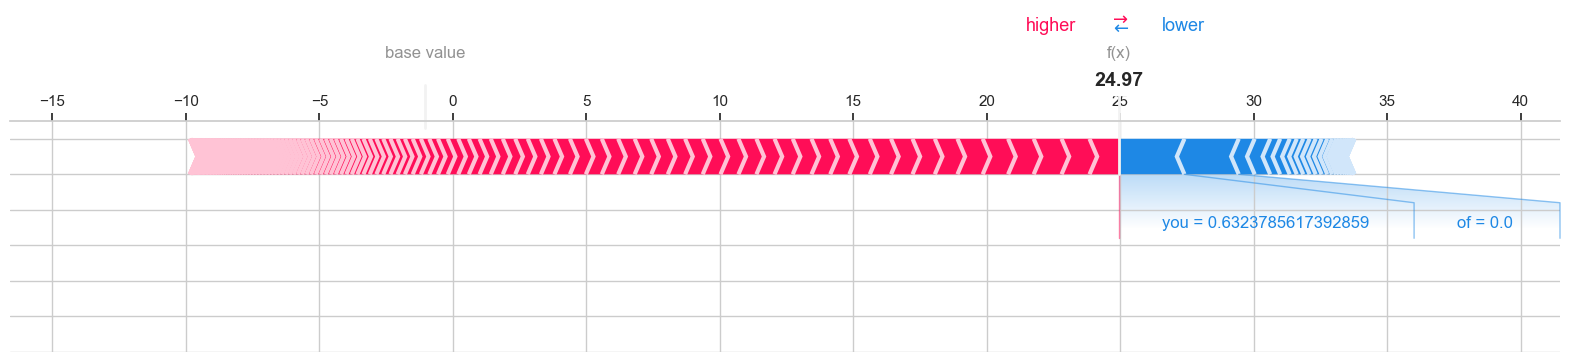

In [ ]:
i = 15

# Get values for one example prediction
shap_vals_row = shap_values[i] 
features_row = X_test_disp.iloc[i]

# Filter only top contributing features
nonzero_idx = np.abs(shap_vals_row) > 0.001
filtered_vals = shap_vals_row[nonzero_idx]
filtered_features = features_row[nonzero_idx]

shap.force_plot( 
    explainer.expected_value,
    filtered_vals,
    filtered_features,
    matplotlib=True
)

The SHAP force plot highlights the word "you" as a significant contributor to the model’s bias prediction in this example. This aligns with research suggesting that direct, imperative phrasing in job descriptions—such as “you must have...” or “you are expected to...” —can inadvertently discourage female applicants. Such phrasing tends to resonate more with male candidates, particularly when paired with assertive or experience-heavy requirements. While the word "you" is not inherently biased, its contextual use in directive language may reflect a more masculine-coded communication style, which the model has learned to associate with biased patterns.

### Lexicon-based bias detection system

The final model presented in this analysis is a lexicon-based bias detection system. It identifies bias-related terms within job descriptions and provides neutral-coded synonym suggestions to reduce potential bias. This enables hiring managers to pinpoint specific instances of biased language and consider more inclusive alternatives. The model uses tokenization and stemming (via PorterStemmer) to match words effectively, and when a biased term is detected, it outputs the term along with recommended neutral replacements.

In [78]:
biased_synonyms = {
    "sikre": ["understøtte", "bidrage til", "fremme"],
    "ansvar": ["rolle", "opgave", "område"],
    "kvalitet": ["standarder", "resultater", "output"],
    "udvikle": ["forbedre", "styrke", "videreudvikle"],
    "trivsel": ["arbejdsmiljø", "engagement", "medarbejdertilfredshed"],
    "lyst": ["motivation", "interesse", "engagement"],
    "sparring": ["vidensdeling", "feedback"]
}

In [79]:
stemmer = PorterStemmer()

def stem_words(words):
    return [stemmer.stem(word.lower()) for word in words]


def detect_biased_words_synonyms(text, biased_dict):
    # Tokenize and stem job description
    text_tokens = re.findall(r'\b\w+\b', text.lower()) 
    text_stems = stem_words(text_tokens)

    # Prepare stemmed version of the biased dictionary
    stemmed_biased_dict = {stemmer.stem(k): (k, v) for k, v in biased_dict.items()} 

    results = []
    for idx, stem in enumerate(text_stems):
        if stem in stemmed_biased_dict:
            original_word = text_tokens[idx]
            biased_word, alternatives = stemmed_biased_dict[stem]
            results.append({
                "matched_word": original_word,
                "biased_word": biased_word,
                "suggestions": alternatives
            })

    return results

In [80]:
# Load CSV
df = pd.read_csv("job_descriptions.csv", encoding="utf-8")  

def analyze_jobs(df, biased_synonyms):
    results = []

    for idx, row in df.iterrows():
        title = row["title"]
        description = row["description"]

        output = detect_biased_words_synonyms(description, biased_synonyms)

        results.append({
            "Job Title": title,
            "Biased Words Found": output
        })

    return results

# Run detection
job_results = analyze_jobs(df, biased_synonyms) 

# Print output
for job in job_results[:5]: 
    print(f"Job Title: {job['Job Title']}")
    
    if job['Biased Words Found']:
        # Track printed stems to avoid duplicates
        printed_stems = set()

        for item in job['Biased Words Found']:
            stemmed_word = stemmer.stem(item['biased_word'])
            if stemmed_word not in printed_stems:
                print(f"  - Found: '{item['biased_word']}', Suggest: {', '.join(item['suggestions'])}")
                printed_stems.add(stemmed_word)
    else:
        print("  - No biased words found.")
    print("-" * 50)

Job Title: Teamleder til drift af Køge Kraftvarmeværk Ny
  - Found: 'sikre', Suggest: understøtte, bidrage til, fremme
  - Found: 'trivsel', Suggest: arbejdsmiljø, engagement, medarbejdertilfredshed
  - Found: 'udvikle', Suggest: forbedre, styrke, videreudvikle
  - Found: 'ansvar', Suggest: rolle, opgave, område
  - Found: 'sparring', Suggest: vidensdeling, feedback
--------------------------------------------------
Job Title: Studentermedhjælper i Administrationen hos Specialisterne
  - Found: 'udvikle', Suggest: forbedre, styrke, videreudvikle
  - Found: 'ansvar', Suggest: rolle, opgave, område
  - Found: 'kvalitet', Suggest: standarder, resultater, output
--------------------------------------------------
Job Title: Servicetekniker
  - Found: 'sikre', Suggest: understøtte, bidrage til, fremme
  - Found: 'kvalitet', Suggest: standarder, resultater, output
  - Found: 'udvikle', Suggest: forbedre, styrke, videreudvikle
--------------------------------------------------
Job Title: Attra

## Further work
A bias detection system, like the one developed in this project, has strong potential for real-world application in reducing unconscious bias in recruitment processes. Research shows that bias often enters already at the talent attraction phase, particularly through the language used in job advertisements, which can subtly favor or discourage certain groups. 

One direct application could be for organizations, such as DTU, to test their own recruitment materials by running their historical and current job descriptions through the model to identify patterns of bias. Although it was not possible within this project to obtain DTU’s own data for analysis, such internal testing would provide valuable insights into potential systemic issues. 

In practice, bias detection systems could be embedded directly into HR workflows: for instance, flagging potentially biased language before a job posting is published, or providing bias reduction suggestions automatically. Over time, organizations could also track changes in language use and measure whether interventions have improved inclusivity. 

Beyond recruitment, similar techniques could be applied to other organizational texts - such as promotion criteria, internal communications, and performance evaluations, helping foster a more diverse and equitable environment at multiple stages of the employee lifecycle.